# Dependencies

In [1]:
!pip install tensorflow==1.15

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


# GAN

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = mnist.load_data()
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
               self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

# Train

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=26000, batch_size=64, sample_interval=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params:

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.616976, acc.: 50.78%] [G loss: 0.543997]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
21001 [D loss: 0.662679, acc.: 64.06%] [G loss: 0.932472]
21002 [D loss: 0.641201, acc.: 62.50%] [G loss: 1.009351]
21003 [D loss: 0.651080, acc.: 64.06%] [G loss: 0.927737]
21004 [D loss: 0.654148, acc.: 57.03%] [G loss: 0.901638]
21005 [D loss: 0.686799, acc.: 54.69%] [G loss: 0.877103]
21006 [D loss: 0.673418, acc.: 59.38%] [G loss: 0.906666]
21007 [D loss: 0.659657, acc.: 56.25%] [G loss: 0.939688]
21008 [D loss: 0.619140, acc.: 67.19%] [G loss: 0.943878]
21009 [D loss: 0.652045, acc.: 62.50%] [G loss: 0.976232]
21010 [D loss: 0.638651, acc.: 62.50%] [G loss: 0.916126]
21011 [D loss: 0.687335, acc.: 56.25%] [G loss: 0.959819]
21012 [D loss: 0.635865, acc.: 64.06%] [G loss: 0.920171]
21013 [D loss: 0.639784, acc.: 56.25%] [G loss: 0.908942]
21014 [D loss: 0.673129, acc.: 55.47%] [G loss: 0.915088]
21015 [D loss: 0.684319, acc.: 57.03%] [G loss: 0.942160]
21016 [D loss: 0.648595, acc.: 64.84%] [G loss: 0.899482]
21017 [D loss: 0.6369

# Visualize

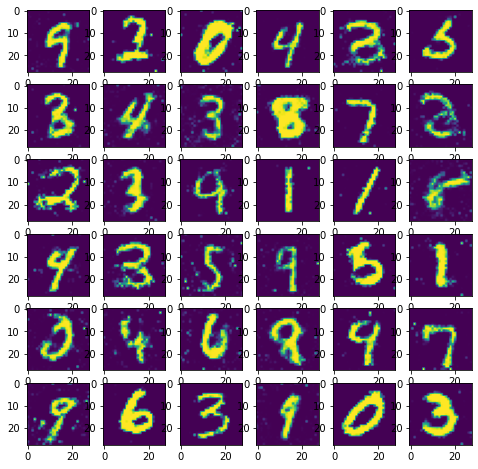

In [6]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

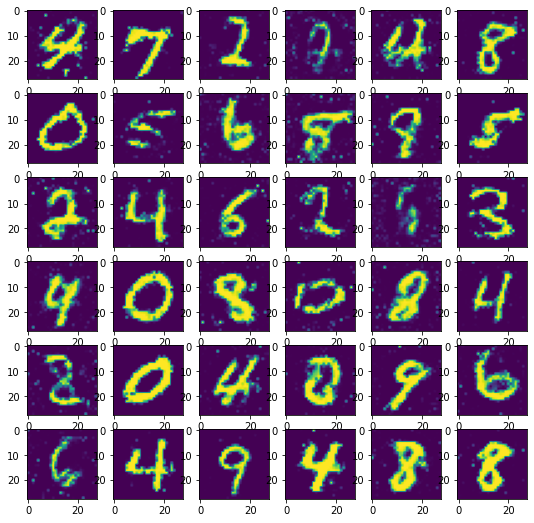

In [7]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(9, 9))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

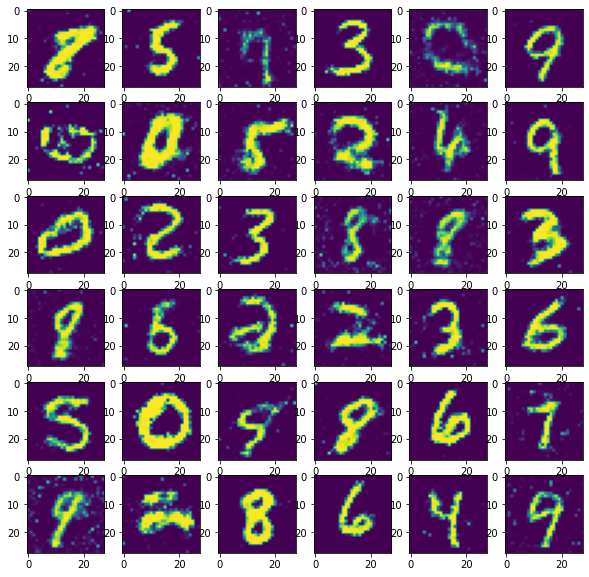

In [8]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

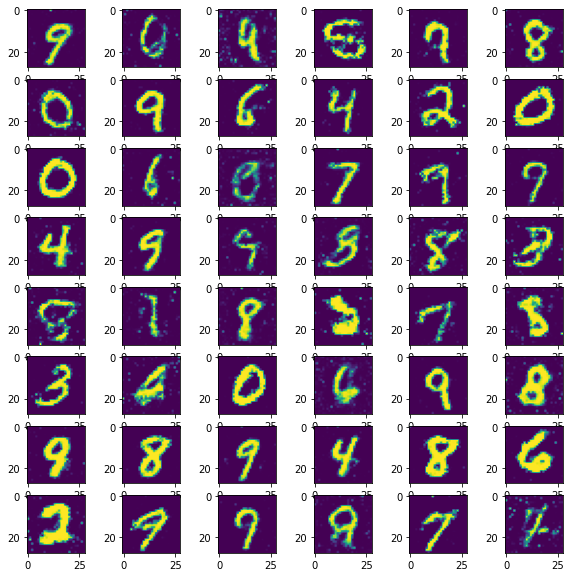

In [9]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (48,100))
gen_imgs= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 8
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()